Computing basic statistics of data

In [3]:
import networkx as nx

def not_metanodes(node):
    return G_with_metanodes.nodes[node].get('meta') != True
def not_metanodes_edges(u, v):
    return G_with_metanodes.nodes[u].get('meta') != True and G_with_metanodes.nodes[v].get('meta') != True

G_with_metanodes = nx.read_graphml("../../dataExtracted/THE_GRAPH.graphml")
# Load graph 
G = nx.subgraph_view(G_with_metanodes,filter_node=not_metanodes,filter_edge=not_metanodes_edges)
n_nodes=G.number_of_nodes()
n_edges=G.number_of_edges()
density= nx.density(G)
avg_degree= sum(dict(G.degree()).values()) / n_nodes
avg_clustering= nx.average_clustering(G)
largest_cc= max(nx.connected_components(G), key=len)
avg_shortest_path=nx.average_shortest_path_length(G.subgraph(largest_cc))
diameter=nx.diameter(G.subgraph(largest_cc))

#with the metanodes
largest_cc_meta= max(nx.connected_components(G_with_metanodes), key=len)
avg_shortest_path_meta=nx.average_shortest_path_length(G_with_metanodes.subgraph(largest_cc_meta))
diameter_meta=nx.diameter(G_with_metanodes.subgraph(largest_cc_meta))

print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")
print(f"Density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Average clustering coefficient: {avg_clustering:.3f}")
print(f"Average shortest path (largest CC): {avg_shortest_path:.2f}")
print(f"Diameter (largest CC): {diameter}")
print(f"Average shortest path for the metagraph (largest CC): {avg_shortest_path_meta:.2f}")
print(f"Diameter for the metagraph (largest CC): {diameter_meta}")


Nodes: 1018
Edges: 1273
Density: 0.0025
Average degree: 2.50
Average clustering coefficient: 0.035
Average shortest path (largest CC): 12.40
Diameter (largest CC): 43
Average shortest path for the metagraph (largest CC): 8.65
Diameter for the metagraph (largest CC): 20


Degree distribution plot and CCDF


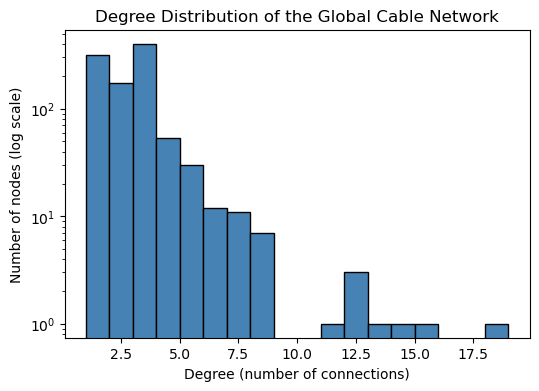

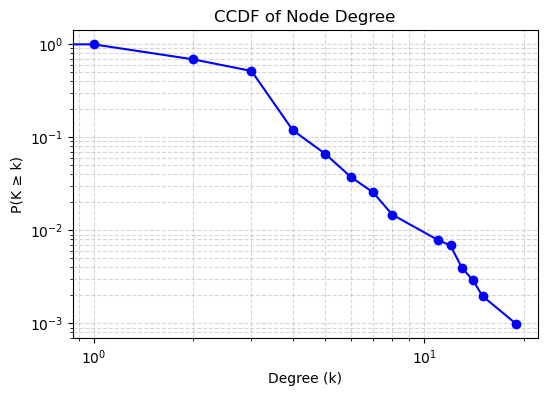

Calculating best minimal value for power law fit
Alpha: 3.503s: 92%
xmin: 4.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=range(1, max(degrees)+1), color='steelblue', edgecolor='black', log=True)
plt.xlabel("Degree (number of connections)")
plt.ylabel("Number of nodes (log scale)")
plt.title("Degree Distribution of the Global Cable Network")
plt.show()
deg_freq= dict(Counter(degrees))
deg_freq = dict(sorted(deg_freq.items()))
degrees_sorted = list(deg_freq.keys())
counts = np.array(list(deg_freq.values()))
ccdf = np.cumsum(counts[::-1])[::-1] / sum(counts)
plt.figure(figsize=(6,4))
plt.loglog(degrees_sorted, ccdf, marker='o', linestyle='-', color='b')
plt.xlabel('Degree (k)')
plt.ylabel('P(K ≥ k)')
plt.title('CCDF of Node Degree')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


fit = powerlaw.Fit(degrees, discrete=True) #checking powerlaw
print(f"Alpha: {fit.alpha:.3f}")
print(f"xmin: {fit.xmin}")




Comparing clustering of the graph to a random graph

In [5]:
import networkx as nx
import numpy as np

def largest_cc(G):
    cc = max(nx.connected_components(G), key=len)
    return G.subgraph(cc).copy()

def config_simple(degrees):
    Gm = nx.configuration_model(degrees)
    Gs = nx.Graph(Gm)                           # merge multiedges
    Gs.remove_edges_from(nx.selfloop_edges(Gs)) # drop self loops
    return Gs

def sample_stats(G):
    H = largest_cc(G)
    return dict(
        clustering = nx.average_clustering(G),        # whole graph
        asp        = nx.average_shortest_path_length(H),
        diameter   = nx.diameter(H),
        lcc_size   = H.number_of_nodes()
    )

# --- ensemble ---
n, m = G.number_of_nodes(), G.number_of_edges()
degrees = [d for _, d in G.degree()]

K = 100  # number of samples
er_stats, cfg_stats = [], []

for _ in range(K):
    Ger = nx.gnm_random_graph(n, m)
    er_stats.append(sample_stats(Ger))

    Gcfg = config_simple(degrees)
    cfg_stats.append(sample_stats(Gcfg))

# summarize
def summarize(stats, key):
    arr = np.array([s[key] for s in stats])
    return float(arr.mean()), float(arr.std())

for key in ["clustering", "asp", "diameter", "lcc_size"]:
    mu, sd = summarize(er_stats, key)
    print(f"ER {key}: {mu:.3f} ± {sd:.3f}")
    mu, sd = summarize(cfg_stats, key)
    print(f"CFG {key}: {mu:.3f} ± {sd:.3f}")

# z-score example for clustering vs ER
real_clust = nx.average_clustering(G)
mu, sd = summarize(er_stats, "clustering")
z = (real_clust - mu) / sd
print(f"Real clustering: {real_clust:.3f}, z_vs_ER = {z:.2f}")





ER clustering: 0.002 ± 0.001
CFG clustering: 0.002 ± 0.001
ER asp: 7.288 ± 0.119
CFG asp: 7.599 ± 0.125
ER diameter: 17.050 ± 1.244
CFG diameter: 18.480 ± 1.729
ER lcc_size: 910.710 ± 9.186
CFG lcc_size: 955.970 ± 10.673
Real clustering: 0.035, z_vs_ER = 27.03


the correlation between the degree of nodes and the mean and median  capacity of a node

In [6]:
import networkx as nx
import pandas as pd
import numpy as np


# ensure 'capacity' exists & is numeric
# convert capacities to numersic, set to NaN if conversion fails
for u, v, data in G.edges(data=True):
    if 'capacity' in data:
        try:
            data['capacity'] = float(data['capacity'])
        except Exception:
            data['capacity'] = np.nan
    else:
        data['capacity'] = np.nan

# degree per node 
degree_series = pd.Series(dict(G.degree()), name="degree") 

# collect edge capacities per node
caps = {n: [] for n in G.nodes()}
for u, v, data in G.edges(data=True):
    cap = data.get('capacity', np.nan)
    if not np.isnan(cap):
        caps[u].append(cap)
        caps[v].append(cap)

# calculate mean/median capacities per node
mean_capacity = {n: (np.mean(vals) if len(vals) > 0 else np.nan) for n, vals in caps.items()}
median_capacity = {n: (np.median(vals) if len(vals) > 0 else np.nan) for n, vals in caps.items()}


node_df = pd.DataFrame({
    'degree': degree_series,
    'mean_capacity': pd.Series(mean_capacity),
    'median_capacity': pd.Series(median_capacity),
})


# correlations
pearson_mean = node_df['degree'].corr(node_df['mean_capacity'], method='pearson')
pearson_median = node_df['degree'].corr(node_df['median_capacity'], method='pearson')
spearman_mean = node_df['degree'].corr(node_df['mean_capacity'], method='spearman')
spearman_median = node_df['degree'].corr(node_df['median_capacity'], method='spearman')

print(f"Pearson correlation (degree vs mean capacity): {pearson_mean:.3f}")
print(f"Pearson correlation (degree vs median capacity): {pearson_median:.3f}")
print(f"Spearman correlation (degree vs mean capacity): {spearman_mean:.3f}")
print(f"Spearman correlation (degree vs median capacity): {spearman_median:.3f}")   


Pearson correlation (degree vs mean capacity): -0.017
Pearson correlation (degree vs median capacity): -0.015
Spearman correlation (degree vs mean capacity): 0.084
Spearman correlation (degree vs median capacity): 0.072
